In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import json
from ctypes import *
import time
%matplotlib inline

In [2]:
# cuda init
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.MSELoss()

# variable init
board_size = 30
batch_size = 128
running_loss = 0.1

losses = []
train_set = []

# ctypes init
f = CDLL("./Simulate.so")
class Snake(Structure):
    _fields_ = [("array", (c_int * 2) * 900)]
class Paths(Structure):
    _fields_ = [("lengths", (c_int * 4)),
                ("array", ((c_int * 2) * 900) * 4)]
dataset_type = c_int * (900 * 450 * 2)
point_type = c_int * (2)

In [3]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ResBlock(1, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            nn.MaxPool2d(3, stride=2),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            nn.MaxPool2d(3, stride=2),
            ResBlock(256, 256),
            ResBlock(256, 256),
            nn.MaxPool2d(3, stride=2),
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x):
        return self.layers(x)

In [5]:
# load model
# model = torch.load("model.pt")
model = ResNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # reiniting adam is pretty bad (avoid)
# optimizer.load_state_dict(torch.load("optimizer_state_dict.pt"))

model.to(device)

ResNet(
  (layers): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(1, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResBlock(
      (conv1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
 

In [6]:
def train():
    global running_loss
    for epoch in range(10000):
        dataset = []
        raw_dataset = dataset_type()
        length = f.simulate(raw_dataset)
        for row_index in range(length):
            temp = []
            for col_index in range(row_index):
                t = (raw_dataset[int(row_index * (row_index + 1) / 2 + col_index) * 2], raw_dataset[int(row_index * (row_index + 1) / 2 + col_index) * 2 + 1])
                temp.append(t)
            dataset.append(temp)

        for sample in dataset:
            rand = int(np.random.rand() * len(train_set))
            sample.append(len(sample))
            sample.append(length/900)
            train_set.append(sample)
            if len(train_set) > 10000:
                train_set.remove(train_set[rand])

        batch = torch.zeros(1, 1, 30, 30, device=device)
        labels = torch.zeros(batch_size, 1, device=device)

        for i in range(batch_size):
            rand = int(np.random.rand() * len(train_set))
            sample = train_set[rand][:len(train_set[rand]) - 2]
            labels[i] = train_set[rand][len(train_set[rand]) - 1:][0]
            board = torch.zeros(board_size, board_size, device=device)
            for number, tupl in enumerate(sample):
                board[tupl] = ((number + 1)/len(sample))
            batch = torch.cat([batch, board.view(1, 1, 30, 30)], dim=0)

        batch = torch.cat((batch[:0], batch[0+1:])) # remove first row
        optimizer.zero_grad()
        outputs = model(batch) #(length, moves)
        loss = loss_function(outputs, labels)
        running_loss = (running_loss * 0.9) + (loss.item() * 0.1)
        losses.append(running_loss)
        loss.backward()
        optimizer.step()

In [7]:
@torch.no_grad()
def dist():
    y = np.zeros(900)
    
    for i in train_set:
        y[int(i[len(i)-1]*900)] += 1
    #     raw_dataset = dataset_type()
    #     length = f.simulate(raw_dataset)
    #     y[length] += 1
    # print(np.argmax(y))
    x = np.arange(900)
    plt.bar(x, y, width=1)
    plt.show()

In [8]:
@torch.no_grad()
def eval(xs, ys, zs):
    total_eval_loss = 0
    model.eval()
    for index, val in enumerate(train_set):
        board = torch.zeros(board_size, board_size, device=device)
        eval_loss = 0
        sample = val[:len(val) - 2]
        label = val[len(val) - 1:][0]
        length = val[len(val) - 2:][0]
        for number, tupl in enumerate(sample):
            board[tupl] = ((number + 1)/len(sample))

        output = (model(board.view(1, 1, board_size, board_size)))
        output_float = float(output.item())

        eval_loss = np.power((output_float - label), 2)
        total_eval_loss += eval_loss

        zs.append(length)
        xs.append(output_float*900)
        ys.append(label*900)
    
    plt.xlabel("predicted score")
    plt.ylabel("actual score")
    plt.xlim([0, 300])
    plt.ylim([0, 300])
    plt.plot(np.arange(50, 250), np.arange(50, 250), color="orange")
    plt.scatter(xs, ys, s=50, c=zs, cmap='Greens_r')
    print("eval_loss: " + str(total_eval_loss/10000))
    model.train()

In [9]:
@torch.no_grad()
def loss():
    smooth = 1
    start = 1
    x = np.arange(len(losses)/smooth)
    y = torch.tensor(losses).view(smooth, -1).mean(0)
    c, b = np.polyfit(x[start:], y[start:], 1)
    plt.plot(x[start:], y[start:])
    plt.plot(x[start:], c*x[start:]+b)

In [10]:
@torch.no_grad()
def simulate():
    c_snake = Snake()
    length = 0
    py_snake = []
    paths = Paths()
    for epoch in range(1):
        while True:
            apple = (int(np.random.rand(1) * board_size), int(np.random.rand(1) * board_size))
            if apple not in py_snake:
                break
        f.search(point_type(c_snake.array[0][0], c_snake.array[1][0]), point_type(apple[0], apple[1]), byref(c_snake), length, byref(paths), 1)
        if paths.lengths[0] == 0: # stops prematurely
            return
        lowest_index = -1
        lowest_score = 1000
        # loop through all returns paths and find the one with the best score (evaluated by the network)
        for i in range(4):
            board = torch.zeros(board_size, board_size, device=device)
            for n in range(paths.lengths[i]):
                board[(paths.array[i][n][0], [paths.array[i][n][1]])] = ((n + 1)/paths.lengths[i])
            model.eval()
            score = model(board.view(1, 1, 30, 30)).item()
            print(score)
            if(score < lowest_score):
                lowest_score = score
                lowest_index = i
        length = paths.lengths[lowest_index]
        path = []
        # copy path with best score into a python list
        for n in range(paths.lengths[lowest_index]):
            path.append((paths.array[lowest_index][n][0], paths.array[lowest_index][n][1]))
        path = path + py_snake
        py_snake.append((0, 0))
        for i, piece in enumerate(py_snake):
            py_snake[i] = path[i]
        # copy python list into c snake array
        for i in range(len(py_snake)):
            c_snake.array[i][0] = py_snake[i][0]
            c_snake.array[i][1] = py_snake[i][1]

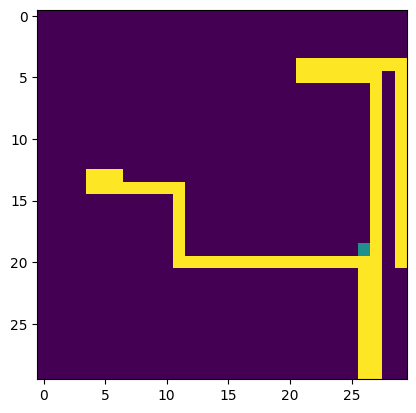

In [3]:
snake = [(20, 29),(19, 29),(18, 29),(17, 29),(16, 29),(15, 29),(14, 29),(13, 29),(12, 29),(11, 29),(10, 29),(9, 29),(8, 29),(7, 29),(6, 29),(5, 29),(4, 29),(4, 28),(4, 27),(4, 26),(4, 25),(4, 24),(4, 23),(4, 22),(4, 21),(5, 21),(5, 22),(5, 23),(5, 24),(5, 25),(5, 26),(5, 27),(6, 27),(7, 27),(8, 27),(9, 27),(10, 27),(11, 27),(12, 27),(13, 27),(14, 27),(15, 27),(16, 27),(17, 27),(18, 27),(19, 27),(20, 27),(21, 27),(22, 27),(23, 27),(24, 27),(25, 27),(26, 27),(27, 27),(28, 27),(29, 27),(29, 26),(28, 26),(27, 26),(26, 26),(25, 26),(24, 26),(23, 26),(22, 26),(21, 26),(20, 26),(20, 25),(20, 24),(20, 23),(20, 22),(20, 21),(20, 20),(20, 19),(20, 18),(20, 17),(20, 16),(20, 15),(20, 14),(20, 13),(20, 12),(20, 11),(19, 11),(18, 11),(17, 11),(16, 11),(15, 11),(14, 11),(14, 10),(14, 9),(14, 8),(14, 7),(14, 6),(14, 5),(14, 4),(13, 4),(13, 5),(13, 6),]
# path = [(24, 5), (24, 6), (24, 7), (24, 8), (24, 9), (24, 10), (24, 11), (24, 12), (24, 13), (24, 14), (24, 15), (24, 16), (24, 17), (24, 18), (24, 19), (24, 20), (24, 21), (23, 21), (22, 21), (21, 21), (20, 21), (19, 21), (18, 21), (17, 21), (16, 21), (15, 21), (14, 21), (13, 21), (12, 21), (11, 21), (10, 21), (9, 21), (8, 21), (7, 21), (7, 20), ]
board = np.zeros((30, 30))
# for i, val in enumerate(path):
#     board[val] = 0.2
for i, val in enumerate(snake):
    board[val] = 1
    board[(19, 26)] = 0.5
plt.imshow(board)

In [4]:
snake = [(7, 20),(8, 20),(9, 20),(10, 20),(11, 20),(12, 20),(13, 20),(14, 20),(15, 20),(15, 19),(15, 18),(15, 17),(15, 16),(15, 15),(15, 14),(14, 14),(14, 13),(14, 12),(14, 11),(14, 10),(14, 9),(14, 8),(14, 7),(13, 7),(12, 7),(11, 7),(11, 6),(10, 6),(10, 7),(9, 7),(9, 6),(8, 6),(8, 7),(7, 7),(7, 6),(6, 6),(6, 5),(5, 5),(5, 4),(4, 4),(4, 3),(3, 3),(2, 3),(2, 4),(3, 4),(3, 5),(4, 5),(4, 6),(5, 6),(5, 7),(6, 7),(6, 8),(7, 8),(8, 8),(9, 8),(10, 8),(11, 8),(12, 8),(13, 8),(13, 9),(13, 10),(13, 11),(13, 12),(13, 13),(13, 14),(13, 15),(14, 15),(14, 16),(14, 17),(14, 18),]
for i in range(len(snake)):
    for w in range(2):
        print("snake.array[" + str(i) + "][" + str(w) + "] = " + str(snake[i][w]) + ";")


snake.array[0][0] = 7;
snake.array[0][1] = 20;
snake.array[1][0] = 8;
snake.array[1][1] = 20;
snake.array[2][0] = 9;
snake.array[2][1] = 20;
snake.array[3][0] = 10;
snake.array[3][1] = 20;
snake.array[4][0] = 11;
snake.array[4][1] = 20;
snake.array[5][0] = 12;
snake.array[5][1] = 20;
snake.array[6][0] = 13;
snake.array[6][1] = 20;
snake.array[7][0] = 14;
snake.array[7][1] = 20;
snake.array[8][0] = 15;
snake.array[8][1] = 20;
snake.array[9][0] = 15;
snake.array[9][1] = 19;
snake.array[10][0] = 15;
snake.array[10][1] = 18;
snake.array[11][0] = 15;
snake.array[11][1] = 17;
snake.array[12][0] = 15;
snake.array[12][1] = 16;
snake.array[13][0] = 15;
snake.array[13][1] = 15;
snake.array[14][0] = 15;
snake.array[14][1] = 14;
snake.array[15][0] = 14;
snake.array[15][1] = 14;
snake.array[16][0] = 14;
snake.array[16][1] = 13;
snake.array[17][0] = 14;
snake.array[17][1] = 12;
snake.array[18][0] = 14;
snake.array[18][1] = 11;
snake.array[19][0] = 14;
snake.array[19][1] = 10;
snake.array[20][0] = 14

In [11]:
simulate()

0.01845613867044449
0.018459152430295944
0.018019501119852066
0.017639964818954468


In [11]:
train()

OSError: exception: access violation reading 0x0000000000000021

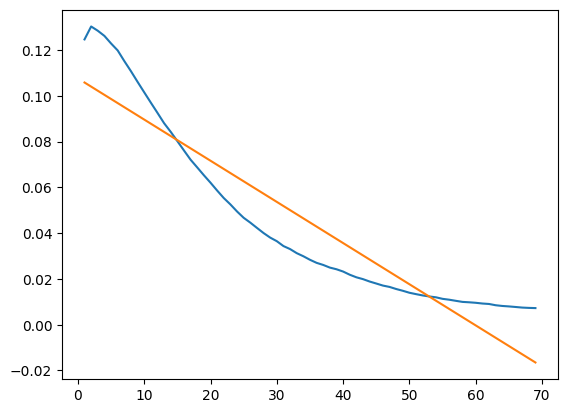

In [15]:
loss()

eval_loss: 0.007268683359152486


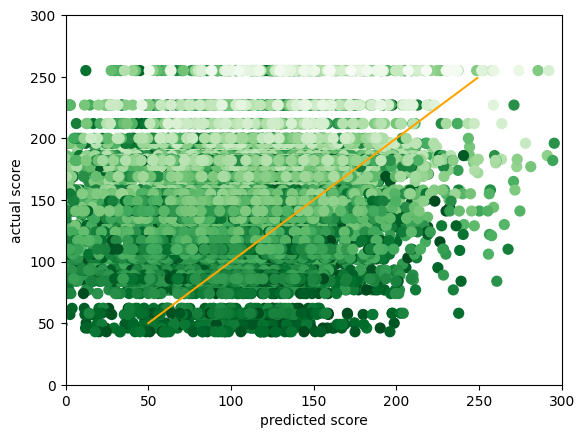

In [17]:
xs = []
ys = []
zs = []

eval(xs, ys, zs)

In [32]:
torch.save(model, "model.pt")
torch.save(optimizer.state_dict(), "optimizer_state_dict.pt")